# Regulated Push-Pull Converter

Due to push-pull topology being prone to flux imbalances, this design uses current-mode PWM controller [UCx846](http://www.ti.com/lit/ds/symlink/uc3846.pdf) (UC1846, UC2846, UC3846).

## Push-pull topology

A typical current-mode half-bridge converter looks like this:

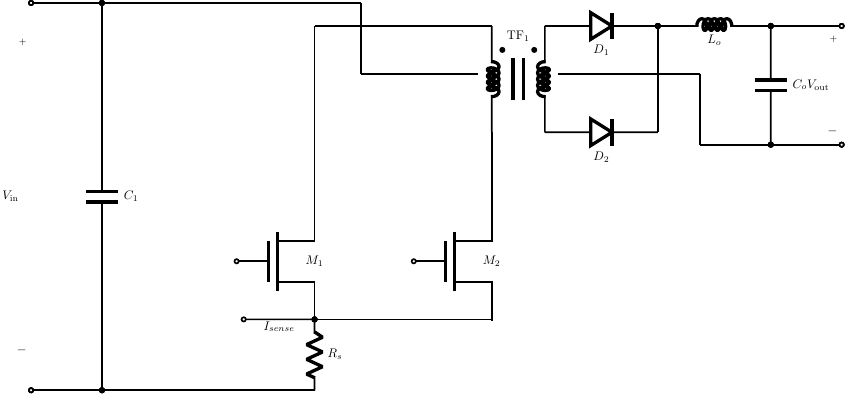

In [1]:
from IPython.display import display, Markdown, Image
import edcalc.schematics
display(Image(edcalc.schematics.push_pull_topology_image()))

A push-pull converter can be viewed as an interleaved forward converter.
Also, fundamentally it is just a buck converter with a transformer
scaling the input voltage to a necessary level. Which means if
you ignore the transformer, it is just a buck converter built
around the inductor Lo. The output of the transformer can be rectified
by either a center-tapped or a full-bridge rectifier.

Some major pros and cons of the topology:

Pros:

* Provides all the benefits of a forward converter
  but with smaller input and output current ripple.
* Relatively easy to build. In most cases doesn't require any gate drivers.
* Can handle power levels of up to 1kW.

* Both full core reset and clamping leakage inductance spikes are
  achieved without the need for extra windings or energy-dissipating
  snubbers (although a snubber across the primary winding can still be handy).

Cons:

* Both switches experience theoretical voltage stress of $2 \times V_{in}$
  (Because when $V_{in}$ is applied to one half of the primary winding,
  it induces the same voltage in the other half, thus doubling the voltage
  applied to the non-conducting transistor).
  Normally the voltage stress is more than $2 \times V_{in}$ due to voltage
  spikes caused by the uncoupled leakage inductance of the transformer,
  unless dampened by a clamp or a snubber circuit.
  Such $2 \times V_{in}$ voltage stress makes push-pull converters less attractive for high input
  voltages such as european 240 VAC, requiring the use of expensive switches
  rated for 800-900V.
* Core flux imbalances can easily occur and accumulate, eventually leading to core
  saturation and destruction of the main switches, so mostly such supplies are build using current-mode control.

## Design parameters

In [2]:
from edcalc.component_types import Core, MOSFET, Diode
from edcalc.smps import OutputParams
from edcalc.components import cores, diodes

# Desired main switching frequency, Hz
# It may later be adjusted according to the real values of the capacitors/resistors of the oscillator,
# leading to a variable called 'F_sw'.
# It's a combined frequency of both switches, so each switch will turn on/off with a half of this frequency.
F_sw_desired = 250000

# Input voltage type: "AC" or "DC" 
V_in_type = "DC"
# Input voltage range (min, max)
V_in_range = (10, 10)



# Describe every output. The first one will be regulated
out = [
    OutputParams(V=20, I=12,
                 filter_core=cores['R33x17.8x11.1-MM52'], 
                 rectifier='center-tapped',
                 D=diodes['SB10100'],
                 C=3000e-6, ESR=0.12, C_ripple=0.001),
]

# Expected efficiency
efficiency = 0.8
# Output inductor's ripple ratio (r = dI / I_L) in the worst conditions (when D = D_min)
# Must be less than 2 (to remain in CCM). Ideally, around 0.3-0.5
ripple = 0.4
# Desired duty cycle of a single switch at minimum input voltage.
# The actual value (calculated as 'D_max') will probably be slightly
# different depending on the components selected for the timing circuit.
D_max_desired = 0.8
# Input capacitor voltage ripple ratio dV/V
V_in_ripple = 0.05

### Magnetic elements ###
# The main transformer's core
core = cores['ETD44/22/15-N87']
# Current density, A/mm^2
I_density = 5
# Diameters of various wires available (to choose from), mm
wires_dia = [0.1, 0.25, 0.35, 0.45]
# Percentage the main transformer's uncoupled inductance,
# also known as leakage inductance. Typically it is 1-3% (0.01-0.03)
transformer_leakage_rate = 0.005
# Peak flux density for the main transformer, Tesla
# 0.12T is far below a typical saturation density for most ferrites,
# but because in push-pull ΔB is rather large (in comparison with flyback),
# a lower value helps to reduce losses
B_pk = 0.12

### About the main switches ###
switch = MOSFET(C_rss=211e-12, C_iss=3247e-12, R_ds=8e-3, Rt_JC=0.75, Rt_CA=61.25, T_j=175)  # IRF3205
# Voltage driving the main switches (and powering the integrated driver if used), V
V_gs_sw = 10
# Max current driving the switches, A
I_drive_max = 0.4
#### Thermal design parameters ####
# Default ambient temperature, °C
T_ambient = 25
# Case-to-heatsink temperature resistance of the main switch (thermal paste), °C/W (set to None if not used)
Rt_CS_sw = 0.5
# Heatsink-to-ambient temperature resistance of the heatsink installed on the main switch, °C/W (set to None if not used)
Rt_SA_sw = 17
# Case-to-heatsink temperature resistance of the diodes (thermal paste), °C/W (set to None if not used)
Rt_CS_D = 0.5
# Heatsink-to-ambient temperature resistance of the diodes, °C/W (set to None if not used)
Rt_SA_D = 17


### Control circuit
# Resistor measuring current flowing through the main switches, Ohms
R_I_sense = 0.005 / 4
# Reference voltage provided by the PWM controller, V
V_ref = 5.1
# Reference voltage at Pin 5 of UCx846 (non-inverting input of the error amplifier), V
V_eap_ref = V_ref / 2

### Clamps and snubbers
# Diodes used in for non-dissipative clamp on the primary side (can be None)
ndclamp_diode = diodes['SS310']
# Max power dissipated by snubbers across the rectifying diodes, W
P_rectifier_snubber = 0.6
# Parasitic capacitance of the rectifier than needs to be damped, F
C_rectifier_parasitic = 1.8e-9
# Force rectifier snubber's capacitor to a certain value (use None to enable automatic choice), F
# Setting this value makes 'C_rectifier_parasitic' and 'P_rectifier_snubber' options irrelevant.
C_rectifier_snubber = 2e-9

In [3]:
import math
# Some convenient conversions
if V_in_type == 'AC':
    V_in_min = V_in_range[0] * math.sqrt(2)
    V_in_max = V_in_range[1] * math.sqrt(2)
else:
    V_in_min, V_in_max = V_in_range
P_out = [o.I * o.V for o in out]
P_out_sum = sum(P_out)
P_in = P_out_sum / efficiency

In [4]:
from edcalc.format import (format_value, format_C, format_R, format_F, format_V, format_I,
                           format_L, format_W, block_of_values, format_flux_density,
                           warning_message, format_value_with_warning)
from edcalc.eseries import nearest_e12, nearest_e24, find_esum, find_precise_voltage_divider
from edcalc.smps import coil_selection

## Input-output

In [5]:
print(f'Input power (with {efficiency*100}% efficiency): {format_W(P_in)}')
print('Output power:', format_W(P_out_sum))

Input power (with 80.0% efficiency): 300.0W
Output power: 240.0W


## UC3846 oscillator

these calculations are based on [this datasheet on UC3846 from TI](http://www.ti.com/lit/ds/symlink/uc3846.pdf). By setting deadtime to be $ T_d = {1 - D_{max} \over F_{sw}} $ we can derive both time-setting resistor and capacitor.

In [6]:
def uc3846_dead_time(R_t, C_t):
    return 145 * C_t * (7.5 / (7.5 - 3.6e3 / R_t))


def uc3846_frequency(R_t, C_t):
    return 2.2 / (R_t * C_t)

dead_time_required = (1 - D_max_desired) / F_sw_desired
R_t_approx = (145 * 2.2 / dead_time_required + F_sw_desired * 3.6e3 / 7.5) / F_sw_desired
C_t_approx = dead_time_required / (145 * (7.5 / (7.5 - 3.6e3 / R_t_approx)))
C_t_parts = find_esum(C_t_approx)
C_t = sum(C_t_parts)
R_t_parts = find_esum(2.2 / (F_sw_desired * C_t))
R_t = sum(R_t_parts)
F_sw = uc3846_frequency(R_t, C_t)
dead_time = uc3846_dead_time(R_t, C_t)
D_max = 1 - dead_time * F_sw
display(block_of_values(
    ('Desired deadtime:', format_value(dead_time_required, "s")),
    ('Desired period:', f'{format_value(1 / F_sw_desired, "s")} (at {format_F(F_sw_desired)})'),
    ('Chain of time-setting resistors forming $R_T$', ' + '.join([format_R(r) for r in R_t_parts])),
    ('Time-setting capacitors, connected in parallel $C_T$', ' + '.join([format_C(r) for r in C_t_parts])),
    ('Dead time actual:', format_value(dead_time, "s")),
    ('Max duty cycle:', f'{round(D_max, 4)} (please, check that the real circuit does not exceed that!)'),
    ('The actual switching frequency:', format_F(F_sw)),
))

<table><tr><td>Desired deadtime:</td><td>800.0ns</td></tr>
<tr><td>Desired period:</td><td>4.0us (at 250.0kHz)</td></tr>
<tr><td>Chain of time-setting resistors forming $R_T$</td><td>1.8kΩ + 270.0Ω</td></tr>
<tr><td>Time-setting capacitors, connected in parallel $C_T$</td><td>3.9nF + 330.0pF</td></tr>
<tr><td>Dead time actual:</td><td>798.51ns</td></tr>
<tr><td>Max duty cycle:</td><td>0.7994 (please, check that the real circuit does not exceed that!)</td></tr>
<tr><td>The actual switching frequency:</td><td>251.25kHz</td></tr></table>

## The main transformer

In [7]:
# Each half of the primary winding conducts at a lower frequency (F_sw / 2)
# and so the duty cycle for it must be recalculated with respect to that frequency
D_max_halfw = D_max / 2
# The magnetic flux swings from -Bsat/2 to +Bsat/2
# In theory, we can use V_in_min while calculating the number of primary turns at D_max.
# However there is a possibility that during the startup time the converter
# will fail to adjust its duty cycle quickly enough to avoid saturation.
# So we're planning for the worst case scenario, which is V_in_max at D_max.
N_p = math.ceil(V_in_max * D_max / (F_sw * B_pk * core.A_e_mks))
L_p = core.A_L_mks * N_p**2
secondary_turns = [math.ceil(N_p * (o.V/D_max + o.full_diode_drop()) / V_in_min) for o in out]
L_secondary = [core.A_L_mks * ns**2 for ns in secondary_turns]
turns_ratios = [N_p / t for t in secondary_turns]
D_min_halfw_pri = (out[0].V + out[0].full_diode_drop()) * turns_ratios[0] / V_in_max
D_min = 2 * D_min_halfw_pri
dB_pk = V_in_max * D_max / (F_sw * N_p * core.A_e_mks)
display(block_of_values(
    ('Minimum duty cycle $D_{min}$', f'{round(D_min, 2)}'),
    ('Maximum possible flux density at $V_{inMAX}$ (assuming $D_{max}$ is limited by the timing circuit!)', format_flux_density(dB_pk, core.B_sat)),
))

<table><tr><td>Minimum duty cycle $D_{min}$</td><td>1.39</td></tr>
<tr><td>Maximum possible flux density at $V_{inMAX}$ (assuming $D_{max}$ is limited by the timing circuit!)</td><td>91.95mT, which is OK</td></tr></table>

### Primary winding RMS and flat-topped peak currents

based on A. Pressman:
> Current drawn from the DC input source... has ... ramp-on-a-step waveshape...
> To simplify calculation, the pulses in the figure are
> assumed to have an equivalent flat-topped waveshape whose amplitude
> $I_{pft}$ is the value of the current at the center of the ramp.

In [8]:
I_pft = P_out_sum / (efficiency * V_in_min * D_max)
I_pri_rms = I_pft * math.sqrt(D_max)
I_pri_rms_halfw = I_pft * math.sqrt(D_max_halfw)

display(block_of_values(
    (f'Flat-topped peak current entering the center of the primary winding', format_I(I_pft)),
    (f'RMS current at the center of the primary winding', format_I(I_pri_rms)),
    (f'RMS current going through each half of the primary windings', format_I(I_pri_rms_halfw)),
))

<table><tr><td>Flat-topped peak current entering the center of the primary winding</td><td>37.53A</td></tr>
<tr><td>RMS current at the center of the primary winding</td><td>33.55A</td></tr>
<tr><td>RMS current going through each half of the primary windings</td><td>23.73A</td></tr></table>

In [9]:
display(Markdown(f"\n### Primary winding (2 x {N_p} turns, center-tapped, {format_L(L_p)} each half)\n"))
display(coil_selection(F_sw, I_pri_rms_halfw, wires_dia, I_density, N_p, winding_area=core.W_a))

for i, o in enumerate(out):
    display(Markdown(f"\n### Secondary winding #{i + 1} ({'2 X ' if o.is_center_tapped else ''}"
          f"{secondary_turns[i]} turns, {format_L(L_secondary[i])})\n"))
    display(coil_selection(F_sw, out[i].I / (2 if o.is_center_tapped else 1), wires_dia, I_density, secondary_turns[i], winding_area=core.W_a))


### Primary winding (2 x 2 turns, center-tapped, 14.0uH each half)


With the RMS current of 23.73A and max current density of 5 $A/mm^2$, we need at least 4.75 $mm^2$ of cross-sectional copper area available for it. 

Thus the optimum wire dia is: 0.26 $ mm $ (0.05 $mm^2$ each strand)

| wire Ø    | copper Ø  | fully utilized | strands | copper total  | 2 turns occupy |
|-----------|-----------|----------------|---------|---------------|----------------|
| 0.1 $mm$  | 0.1 $mm$  | OK             | 605     | 4.7517 $mm^2$ | 15%            |
| 0.25 $mm$ | 0.25 $mm$ | OK             | 97      | 4.7615 $mm^2$ | 15%            |
| 0.35 $mm$ | 0.35 $mm$ | TOO THICK      | 53      | 4.7895 $mm^2$ | 16%            |
| 0.45 $mm$ | 0.45 $mm$ | TOO THICK      | 37      | 4.8764 $mm^2$ | 18%            |


### Secondary winding #1 (2 X 6 turns, 126.0uH)


With the RMS current of 6.0A and max current density of 5 $A/mm^2$, we need at least 1.2 $mm^2$ of cross-sectional copper area available for it. 

Thus the optimum wire dia is: 0.26 $ mm $ (0.05 $mm^2$ each strand)

| wire Ø    | copper Ø  | fully utilized | strands | copper total  | 6 turns occupy |
|-----------|-----------|----------------|---------|---------------|----------------|
| 0.1 $mm$  | 0.1 $mm$  | OK             | 153     | 1.2017 $mm^2$ | 11%            |
| 0.25 $mm$ | 0.25 $mm$ | OK             | 25      | 1.2272 $mm^2$ | 12%            |
| 0.35 $mm$ | 0.35 $mm$ | TOO THICK      | 14      | 1.2651 $mm^2$ | 13%            |
| 0.45 $mm$ | 0.45 $mm$ | TOO THICK      | 10      | 1.318 $mm^2$  | 15%            |

## Output filters

Please, note that according to A. Pressman:

> The output capacitor Co is selected to meet the maximum output ripple
voltage specification. In Section 1.3.7 it was shown that the output
ripple is determined almost completely by the magnitude of the ESR
(equivalent series resistance, Ro ) in the filter capacitor and not by the
magnitude of the capacitor itself.

The theory is covered in ["Understanding Buck Power Stages"](static/papers/slva057-buck-power-stages.pdf)
by Everett Rogers
and in [Analog Circuit Design Volume 2: Immersion in the Black Art of Analog Design](https://books.google.ru/books?id=H9rAU4Rf--YC&lpg=PA108&pg=PA108#v=onepage&q&f=false)
by Bob Dobkin and Jim Williams.

In [10]:
import importlib; importlib.reload(edcalc.smps)
out_info, L_out, C_out, ESR_C_out = [], [], [], []
for i, o in enumerate(out):
    display(Markdown(f'\n###  Output #{i+1}: ###\n'))
    V_s_in_min = V_in_min / turns_ratios[i] - o.full_diode_drop()
    V_s_in_max = V_in_max / turns_ratios[i] - o.full_diode_drop()
    output_suggestions, extra_info = edcalc.smps.buck_output_params(
        F_sw, V_s_in_min, V_s_in_max, D_min, D_max, o.V, o.I, ripple, o.filter_core, o.C_ripple)
    display(block_of_values(*extra_info))
    display(Markdown('### The winding'))
    display(coil_selection(F_sw, o.I, wires_dia, I_density, output_suggestions.N))
    out_info.append(output_suggestions)
    L_out.append(output_suggestions.L)
    C_out.append(output_suggestions.C if o.C is None else o.C)
    ESR_C_out.append(output_suggestions.ESR if o.ESR is None else o.ESR)

# More realistic estimation of the peak primary current, based on the sum of reflected
# currents of all output inductors
I_pri_pk = sum([out[i].I * (1 + out_info[0].max_ripple / 2) / turns_ratios[0]
                for i in range(len(out))])
display(block_of_values(
    (f'Peak primary winding current', format_I(I_pri_pk)),
))


###  Output #1: ###


<table><tr><td>Output voltage</td><td>20.0V</td></tr>
<tr><td>Output current</td><td>12.0A</td></tr>
<tr><td>Output voltage ripple (0.1%)</td><td>20.0mV</td></tr>
<tr><td>Output inductor</td><td>11.5uH, 11 turns</td></tr>
<tr><td>Inductor mode</td><td>continuous</td></tr>
<tr><td>Inductor's peak flux density</td><td>498.77mT, which is OK</td></tr>
<tr><td>Inductor's peak current:</td><td>38.42A</td></tr>
<tr><td>$r = \Delta I / I_L$ at $V_{inmin}$</td><td>0.21</td></tr>
<tr><td>$r = \Delta I / I_L$ at $V_{inmax}$</td><td>0.37</td></tr>
<tr><td>Recommended minimum capacitor:</td><td>109.54uF</td></tr>
<tr><td>Max ESR of this capacitor should be</td><td>4.54mΩ</td></tr>
<tr><td>Output capacitor RMS current</td><td>1.27A</td></tr>
<tr><td>Such capacitor will dissipate</td><td>7.34mW</td></tr></table>

### The winding

With the RMS current of 12.0A and max current density of 5 $A/mm^2$, we need at least 2.4 $mm^2$ of cross-sectional copper area available for it. 

Thus the optimum wire dia is: 0.26 $ mm $ (0.05 $mm^2$ each strand)

| wire Ø    | copper Ø  | fully utilized | strands | copper total  | 11 turns occupy |
|-----------|-----------|----------------|---------|---------------|-----------------|
| 0.1 $mm$  | 0.1 $mm$  | OK             | 306     | 2.4033 $mm^2$ |                 |
| 0.25 $mm$ | 0.25 $mm$ | OK             | 49      | 2.4053 $mm^2$ |                 |
| 0.35 $mm$ | 0.35 $mm$ | TOO THICK      | 27      | 2.4399 $mm^2$ |                 |
| 0.45 $mm$ | 0.45 $mm$ | TOO THICK      | 19      | 2.5041 $mm^2$ |                 |

<table><tr><td>Peak primary winding current</td><td>42.61A</td></tr></table>

## DC input capacitor

In [11]:
C_in = nearest_e12(I_pft * D_max / (F_sw * V_in_min * V_in_ripple), 'higher')
ESR_C_in = V_in_min * V_in_ripple / I_pft
display(block_of_values(
    ('Minimum recommended input capacitor', format_C(C_in)),
    ('Recommended ESR', format_R(ESR_C_in)),
    ('Minimum voltage rating of the capacitor', format_V(1.2 * V_in_max))
))

<table><tr><td>Minimum recommended input capacitor</td><td>270.0uF</td></tr>
<tr><td>Recommended ESR</td><td>13.32mΩ</td></tr>
<tr><td>Minimum voltage rating of the capacitor</td><td>12.0V</td></tr></table>

## Leakage inductance energy spikes

Each time one of the switches stops conducting, a huge voltage spike occurs at its drain. This is due to the leakage (uncoupled) inductance of the main transformer, which tries to keep the current flowing and thus raises the voltage across its ends. Left ignored, such spikes can destroy the switches.

### Option 1: RCD snubbers

These snubbers dump the parasitic energy burst into heat. They look like this (colored blue, virtual leakage inductance is red):

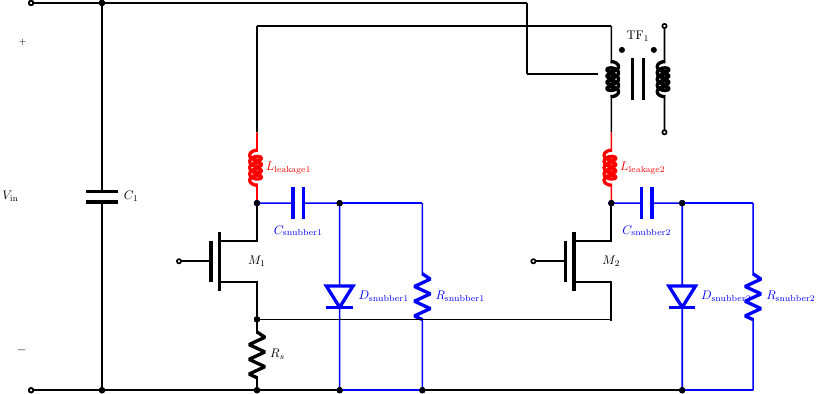

In [12]:
import edcalc.schematics
display(Image(edcalc.schematics.push_pull_rcd_snubber_image()))

How they work:

* each $C_{snubber}$ absorbs about a half of the turn-off current spikes caused by the leakage inductance (designed that way)
* thus reduces transistor dissipation by slowing down drain raise time when the switch stops conducting and giving the switch more time to turn off at lower drain voltage. Important for BJT switches
* by dampening voltage spikes keeps them from destroying the switches

These calculations are based on chapter 11 from "Switching Power Supply Design" by A. Pressman. They are not very precise but practical enough.

Capacitance is $C = {Q \over V}$. We know that $V = 2 \times V_{in}$, and the charge is assumed to be $Q = I * T_{fall}$. If current is set to $I = I_{peak} / 2$, then $$ C_{snubber} = {{T_{fall} {(I_{peak} / 2)}} \over {2 V_{in}}} $$

Knowing $C_{snubber}$ we can calculate the resistance needed to "burn" the absorbed energy when the transistor is turned on. $R_{snubber}$ and $C_{snubber}$ form an [RC-circuit](https://en.wikipedia.org/wiki/RC_circuit) with time constant $\tau = R C$ which can be discharged to 5% of its original voltage in time equal $3 \tau$. So, if we assume $ T_{on} = 3 \tau = 3 R C $ we get $$ R_{snubber} = {{T_{on\_min}} \over {3 C_{snubber}}} = { {D_{min}} \over {3 F_{sw} C_{snubber}}}$$

In [13]:
# Here we assume that turn-on and turn-off periods for a MOSFET are equal
I_C_snubber = I_pft / 2
T_fall = switch.gate_drive_charge(V_in_max, V_gs_sw) / I_drive_max
C_snubber = nearest_e12(I_C_snubber * T_fall / (2 * V_in_min))
R_snubber = nearest_e12(D_min / (3 * F_sw * C_snubber))
L_p_leakage = L_p * transformer_leakage_rate
Z_LC_snubber = math.sqrt(L_p_leakage / C_snubber)
V_spike_sw = 2 * V_in_max + Z_LC_snubber * I_C_snubber
E_snubber = C_snubber * (2 * V_in_max)**2 / 2
P_snubber = E_snubber * F_sw
display(block_of_values(
    ('Assumed $T_{fall}$  time', format_value(T_fall, "s")),
    ('Amplitude of the turn-off voltage spike', format_V(V_spike_sw)),
    ('$C_{snubber}$', format_C(C_snubber)),
    ('$R_{snubber}$', format_R(R_snubber)),
    ('Power dissipated through $R_{snubber}$ each cycle', format_W(P_snubber)),
))

<table><tr><td>Assumed $T_{fall}$  time</td><td>86.45ns</td></tr>
<tr><td>Amplitude of the turn-off voltage spike</td><td>37.34V</td></tr>
<tr><td>$C_{snubber}$</td><td>82.0nF</td></tr>
<tr><td>$R_{snubber}$</td><td>22.0Ω</td></tr>
<tr><td>Power dissipated through $R_{snubber}$ each cycle</td><td>4.12W</td></tr></table>

### Option 2: Isolated passive lossless clamps

This clamp accumulates the energy stored in the leakage inductance and recovers it to the input of the supply. It uses two independent inductances $L_s$.

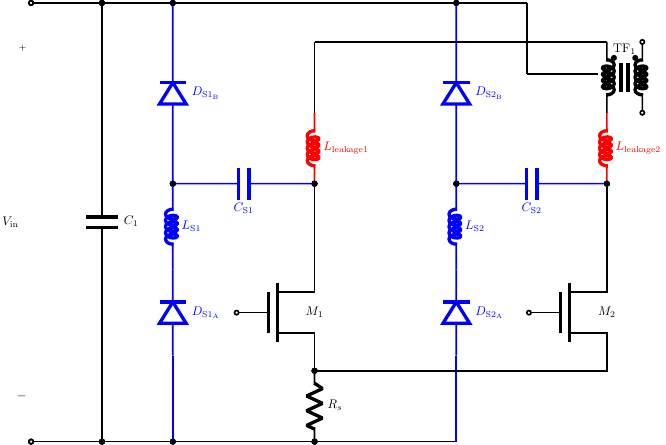

In [14]:
import edcalc.schematics
display(Image(edcalc.schematics.push_pull_lossless_clamp_image()))

The circuit works by dumping the energy of the leakage inductance into a capacitor $C_S$, which is already "pre-charged" to $V_{in}$. The capacitor is selected so that the energy dump doesn't raise its voltage beyound a certail limit `V_clamp_max`. Next time the transistor is conducting, it connects the capacitor to an intermediate inductance $L_S$ during the time $T_{ON}$ (which can be as long as $D_{max} / F_{sw}$). Again, the inductance of $L_S$ is selected so that the capacitor will be only partially discharged to the "pre-charged" voltage $V_{in}$, again. Once the transistor is off again, the inductance $L_S$ will freewheel its current into the input power line through the upper and lower diodes. At the same time, $C_S$ will absorb another energy spike, and the cycle will be repeated. Because $C_S$ stays "pre-charged" to at least $V_{in}$, this keeps diode $D_{SB}$ off when another side of the circuit is conducting.

The calculations below are just rough estimations that seem to work well enough.

In [15]:
clamp1_components, clamp1_info = edcalc.smps.non_dissipative_isolated_clamp(
    V_in_min, V_in_max, I_pri_pk=I_pri_pk, L_leakage=L_p * transformer_leakage_rate,
    T_clamp_on=D_min/F_sw, T_clamp_off=(2 - D_min) / F_sw, V_ripple=0.05)
display(block_of_values(*clamp1_info))

<table><tr><td>Peak current through the upper diode $D_{SB}$</td><td>42.99A</td></tr>
<tr><td>Average current through the upper diode $D_{SB}$</td><td>894.79mA</td></tr>
<tr><td>RMS current through the upper diode $D_{SB}$</td><td>5.06A</td></tr>
<tr><td>Leakage inductance</td><td>70.0nH</td></tr>
<tr><td>Max drain-source voltage:</td><td>20.5V</td></tr>
<tr><td>Min pre-charged voltage on $C_S$</td><td>10.0V</td></tr>
<tr><td>Minimum $L_S$</td><td>50.77uH</td></tr>
<tr><td>Minimum $C_S$</td><td>13.0uF</td></tr>
<tr><td>Peak current through $C_S$</td><td>42.61A</td></tr>
<tr><td>Power recovered by one clamps is</td><td>7.98W</td></tr>
<tr><td>$L_s$ peak-to-peak ripple $\Delta I$</td><td>382.56mA</td></tr>
<tr><td>$L_s$|$D_{SA}$ RMS current $I_{Ls}$</td><td>779.6mA</td></tr>
<tr><td>$L_s$|$D_{SA}$ average current $I_{Ls}$</td><td>791.01mA</td></tr>
<tr><td>$L_s$|$D_{SA}$ peak current</td><td>982.29mA</td></tr>
<tr><td>Max drain-source voltage/reverse voltage across each of the diodes:</td><td>20.5V</td></tr></table>

### Option 3: Nondissipative clamping through recovery reset windings

This method is described in ["Nondissipative Clamping Benefits DC-DC Converters" by By Viktor D. Vogman](https://www.powerelectronics.com/content/article/21857520/nondissipative-clamping-benefits-dcdc-converters) ([pdf version](static/papers/non-dissipative-clamping.pdf)). Unlike the 2nd option, it uses only two diodes, eliminates the extra inductors, however requires a copy of the primary winding on the main transformer called recovery windings (with the same number of turns although a thinner wire).

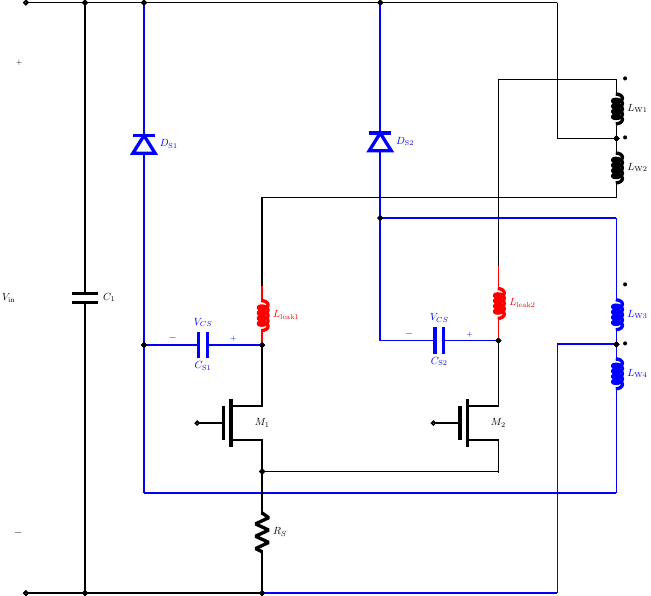

In [16]:
import edcalc.schematics
display(Image(edcalc.schematics.push_pull_coupled_lossless_clamp_image()))

Windings $L_{W1}$, $L_{W2}$, $L_{W3}$ and $L_{W4}$ are all wounded on the same core and in the same direction (say, upside-down as shown on the schematic) and have the same number of turns of the primary winding. The secondary windings are omitted on this diagram.

In [17]:
clamp2_components, clamp2_info = edcalc.smps.non_dissipative_coupled_clamp(
    V_in_min, V_in_max, I_pri_pk=I_pri_pk, L_leakage=L_p * transformer_leakage_rate,
    T_clamp_on=D_min/F_sw, T_clamp_off=(2 - D_min) / F_sw, V_ripple=0.01)
display(block_of_values(*clamp2_info))
display(Markdown(f'#### Extra windings 2 x {N_p} turns, just like the primary'))
display(coil_selection(F_sw, clamp2_components.I_L_rec_rms, wires_dia, I_density, N_p, winding_area=core.W_a))

if ndclamp_diode is not None:
    display(Markdown('#### Working condition of the diodes'))
    display(block_of_values(
        *ndclamp_diode.check_conditions(
            V_max=clamp2_components.V_D,
            I_pk=clamp2_components.I_D_pk,
            I_avg=clamp2_components.I_D_avg),
        *ndclamp_diode.thermal_analysis(
            clamp2_components.I_D_avg,
            Rt_CS=Rt_CS_D,
            Rt_SA=Rt_SA_D)
    ))

<table><tr><td>Minimum $C_S$</td><td>68.0uF</td></tr>
<tr><td>Max $C_S$ voltage</td><td>10.1V</td></tr>
<tr><td>RMS current of the recovery winding</td><td>9.81A</td></tr>
<tr><td>Resonant frequency (must be $<< F_{sw}$)</td><td>3.43uHz</td></tr>
<tr><td>Max drain-source voltage:</td><td>20.0V</td></tr>
<tr><td>$D_S$ reverse voltage</td><td>20.0V</td></tr>
<tr><td>$D_S$ peak current</td><td>42.61A</td></tr>
<tr><td>$D_S$ RMS current</td><td>5.02A</td></tr>
<tr><td>$D_S$ average current</td><td>886.83mA</td></tr></table>

#### Extra windings 2 x 2 turns, just like the primary

With the RMS current of 9.81A and max current density of 5 $A/mm^2$, we need at least 1.96 $mm^2$ of cross-sectional copper area available for it. 

Thus the optimum wire dia is: 0.26 $ mm $ (0.05 $mm^2$ each strand)

| wire Ø    | copper Ø  | fully utilized | strands | copper total  | 2 turns occupy |
|-----------|-----------|----------------|---------|---------------|----------------|
| 0.1 $mm$  | 0.1 $mm$  | OK             | 250     | 1.9635 $mm^2$ | 6%             |
| 0.25 $mm$ | 0.25 $mm$ | OK             | 40      | 1.9635 $mm^2$ | 6%             |
| 0.35 $mm$ | 0.35 $mm$ | TOO THICK      | 22      | 1.9881 $mm^2$ | 7%             |
| 0.45 $mm$ | 0.45 $mm$ | TOO THICK      | 15      | 1.9769 $mm^2$ | 8%             |

#### Working condition of the diodes

<table><tr><td>Diodes connected in parallel</td><td>1</td></tr>
<tr><td>Max reverse voltage on each of the diodes</td><td>20.0V, which is OK</td></tr>
<tr><td>Peak current through each diode</td><td>42.61A, which is OK</td></tr>
<tr><td>Average current per diode</td><td>886.83mA, which is OK</td></tr>
<tr><td>Power being dissipated, per component</td><td>753.8mW</td></tr>
<tr><td>Junction temperature without a heatsink</td><td>81.54°C, which is OK</td></tr>
<tr><td>Junction temperature with the heatsink</td><td>53.27°C, which is OK</td></tr></table>

## Main switches

In [18]:
# Thermal analysis
T_rise = switch.gate_drive_charge(V_in_max, V_gs_sw) / I_drive_max
R_gate_sw = V_gs_sw / I_drive_max

display(block_of_values(
    *switch.thermal_analysis(I_pri_rms_halfw, Rt_CS_sw, Rt_SA_sw),
    (f'Gate resistors:', format_R(R_gate_sw)),
    (f'Rise time', format_value(T_rise, 's')),
    ('Max drain-source voltage:', 'depends on the clamp/snubber chosen'),
    (f'RMS current', format_I(I_pri_rms_halfw)),
    (f'Peak current', format_I(I_pri_pk)),
))

<table><tr><td>Power being dissipated, per component</td><td>4.5W</td></tr>
<tr><td>Junction temperature without a heatsink</td><td>304.22°C <span style="font-weight:bold; color: #ff0000;">WARNING:</span> <span style="font-weight:bold;">Too hot (>= 175.0°C)!</span></td></tr>
<tr><td>Junction temperature with the heatsink</td><td>107.19°C, which is OK</td></tr>
<tr><td>Gate resistors:</td><td>25.0Ω</td></tr>
<tr><td>Rise time</td><td>86.45ns</td></tr>
<tr><td>Max drain-source voltage:</td><td>depends on the clamp/snubber chosen</td></tr>
<tr><td>RMS current</td><td>23.73A</td></tr>
<tr><td>Peak current</td><td>42.61A</td></tr></table>

## Output rectifiers

Leakage inductance of the secondary winding combined with parasitic inductances in the transformer and component junctions, can lead to severe stress on the rectifying diodes. Each diode can experience stress of more than $2 \times V_{in} \times Ns / Np$ due to voltage spikes and ringing caused by those parasitic elements. RC snubbers across the diodes capture and dissipate this energy, both saving the diodes and reducing EMI.

Here's an example of such snubbers on a center-tapped rectifier:

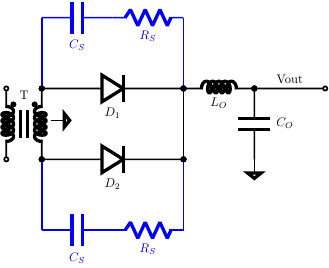

In [19]:
display(Image(edcalc.schematics.rectifier_rc_snubber_image()))

In [20]:
import importlib; importlib.reload(edcalc.schematics); importlib.reload(edcalc.smps)

for i, o in enumerate(out):
    if o.rectifier is None:
        continue
    display(Markdown(f'\n### Output #{i + 1} ({o.rectifier} rectifier) ###'))
    display(Markdown(f'#### RC snubbers for output #{i + 1} diodes'))
    snubber_components, snubber_info = edcalc.smps.rectifier_rc_snubber(
        F_sw=F_sw,
        I_pk=o.I * (1 + out_info[i].max_ripple / 2),
        V_in=V_in_max / turns_ratios[i],
        L_leakage=L_secondary[i] * transformer_leakage_rate,
        C_junction=C_rectifier_parasitic, P_max=P_rectifier_snubber,
        C_snubber=C_rectifier_snubber)
    V_snubber_cap = snubber_components.V_cap * (2 if o.rectifier == 'center-tapped' else 1)
    display(block_of_values(
        *snubber_info,
        ('Peak voltage stress on the protected diode, $C_S$ and $R_S$',
         format_V(V_snubber_cap))
    ))
    display(Markdown(f'#### On the diodes themselves'))
    display(block_of_values(
        *o.D.check_conditions(
            V_max=V_snubber_cap,
            I_avg=o.diode_average_current(),
            I_pk=o.I * (1 + out_info[i].max_ripple / 2)),
        *o.D.thermal_analysis(o.diode_average_current(), T_ambient=T_ambient, Rt_CS=Rt_CS_D, Rt_SA=Rt_SA_D)
    ))




### Output #1 (center-tapped rectifier) ###

#### RC snubbers for output #1 diodes

<table><tr><td>Voltage source</td><td>30.0V</td></tr>
<tr><td>Leakage inductance</td><td>630.0nH</td></tr>
<tr><td>Snubber capacitor $C_S$</td><td>2.0nF</td></tr>
<tr><td>Snubber resistor $R_S$</td><td>36.0Ω</td></tr>
<tr><td>Power dissipated by the snubber</td><td>452.26mW</td></tr>
<tr><td>Characteristic impedance</td><td>17.75Ω</td></tr>
<tr><td>Peak voltage stress on the protected diode, $C_S$ and $R_S$</td><td>89.71V</td></tr></table>

#### On the diodes themselves

<table><tr><td>Diodes connected in parallel</td><td>1</td></tr>
<tr><td>Max reverse voltage on each of the diodes</td><td>89.71V, which is OK</td></tr>
<tr><td>Peak current through each diode</td><td>14.2A, which is OK</td></tr>
<tr><td>Average current per diode</td><td>6.0A, which is OK</td></tr>
<tr><td>Power being dissipated, per component</td><td>5.1W</td></tr>
<tr><td>Junction temperature without a heatsink</td><td>244.3°C <span style="font-weight:bold; color: #ff0000;">WARNING:</span> <span style="font-weight:bold;">Too hot (>= 150.0°C)!</span></td></tr>
<tr><td>Junction temperature with the heatsink</td><td>124.45°C, which is OK</td></tr></table>

## UC3846 Current sensing circuit

![UC3846 current limiting circuit](static/images/uc3846-current-limiting.png)

**$R_2$ should also be shunted with a small capacitor** to get soft-start capability.

In [21]:
V_I_sense = I_pri_pk * R_I_sense
P_I_sense = I_pri_rms**2 * R_I_sense
V_I_sense_divider = 3 * V_I_sense + 0.5
if V_I_sense > 1.2:
    display(warning_message("For UC3846 to operate properly, maximum differential voltages must be kept below 1.2 V at the current sense inputs"))
R_I_sense_upper_parts, R_I_sense_lower = find_precise_voltage_divider(V_ref, V_I_sense_divider, max_current=1e-3, num_r1_parts=2)[0]
R_I_sense_upper = sum(R_I_sense_upper_parts)
I_sense_limit = (R_I_sense_lower * V_ref / (R_I_sense_lower + R_I_sense_upper) - 0.5) / (3 * R_I_sense)

display(block_of_values(
    ('Current sensing resistor $R_s$ (from the design parameters)', format_R(R_I_sense)),
    ('Peak current through $R_s$', format_I(I_pri_pk)),
    ('Max RMS current going through $R_s$', format_I(I_pri_rms)),
    ('Max voltage across $R_s$', format_V(V_I_sense)),
    ('Power dissipated on $R_s$', format_W(P_I_sense)),
    ('Threshold-setting voltage at Pin 1 of UC3846', format_V(V_I_sense_divider)),
    ('Upper resistors $R_1$ in the threshold-setting divider', ' + '.join(format_R(r) for r in R_I_sense_upper_parts)),
    ('Lower resistor $R_2$ in the threshold-setting divider', format_R(R_I_sense_lower)),
    ('Actual current limit with the components suggested', format_I(I_sense_limit)),
))

<table><tr><td>Current sensing resistor $R_s$ (from the design parameters)</td><td>1.25mΩ</td></tr>
<tr><td>Peak current through $R_s$</td><td>42.61A</td></tr>
<tr><td>Max RMS current going through $R_s$</td><td>33.55A</td></tr>
<tr><td>Max voltage across $R_s$</td><td>53.26mV</td></tr>
<tr><td>Power dissipated on $R_s$</td><td>1.41W</td></tr>
<tr><td>Threshold-setting voltage at Pin 1 of UC3846</td><td>659.77mV</td></tr>
<tr><td>Upper resistors $R_1$ in the threshold-setting divider</td><td>4.7kΩ + 820.0Ω</td></tr>
<tr><td>Lower resistor $R_2$ in the threshold-setting divider</td><td>820.0Ω</td></tr>
<tr><td>Actual current limit with the components suggested</td><td>42.57A</td></tr></table>

## Current mode slope compensation for UCx846 (for D > 0.5)

This type of slope compensation is described in application note ["Modelling, analysis and compensation of the current-mode converter"](http://www.ti.com/lit/an/slua101/slua101.pdf) specifically for UCx846 series.

From S. Maniktala:
> It can be shown that to avoid subharmonic instability, we need to ensure that the amount of
  slope compensation (expressed in A/s) is equal to half the slope of the falling inductor
  current ramp, or more.
  
the falling slope is a constant $m_2 = {{V_o} \over {L_o}}$, in A/s. Or, reflected to the primary side, $m_{2OR} = {{N_s} \over {N_p}}{{V_o} \over {L_o}}$. The same thing expressed in V/s would be equal to ${R_s} {{N_s} \over {N_p}}{{V_o} \over {L_o}}$. Divided by two, this is how much compensation we need to add to the current sensing input of the controller.

![Simple slope compensation for UCx846](static/images/uc3846-slope-compensation.png)

A. Pressman in chapter 5 of "Switching Power Supply Design" describes how to choose values $R_1$ and $R_2$, where the following expression is derived:
$$ {{R_1} \over {R_1 + R_2}} = {{(N_s / N_p) (R_s) (m_2 / 2)} \over {\Delta V / \Delta t}}$$

Here $\Delta V/\Delta t$ is the slope of the UCx846 oscillator's waveform. $m_2 = V_o / L_o$ is the downslope of the output inductor.

If R1 is fixed, then $$ R_2 = R_1 \left({{N_p} \over {N_s}} {{2 (\Delta V / \Delta t)} \over {R_s m_2}} - 1\right)$$

In [22]:
# dV/dt of the slope of the sawtooth ramp across the timing capacitor of UCx846
osc_slope = 1.8 / (0.45 * R_t * C_t)  # Slope of the UCx846's oscillator
# charge current flowing into the timing capacitor
I_osc = C_t * osc_slope
# max voltage of the ramp
V_osc = osc_slope / F_sw
# Timing circuit impedance
Z_osc = V_osc / I_osc
# R1-R2 series resistance has to be large to avoid significantly affecting the timing circuit
# So we assign R1 to be at least as large as the impedance of the timing circuit.
R1_slope_comp = nearest_e12(Z_osc, 'higher')
m2_slope = o.V / L_out[0]
R2_slope_comp_parts = find_esum(R1_slope_comp * (turns_ratios[0] * 2 * osc_slope / (R_I_sense * m2_slope) - 1), 3)
R2_slope_comp = sum(R2_slope_comp_parts)
if R1_slope_comp + R2_slope_comp < 100 * Z_osc:
    display(warning_message("R1 + R2 have too small resistance and may affect the timing circuit"))
display(block_of_values(
    ('$R_1$', format_R(R1_slope_comp)),
    ('$R_2$', ' + '.join(format_R(r) for r in R2_slope_comp_parts)),
))

<table><tr><td>$R_1$</td><td>1.0kΩ</td></tr>
<tr><td>$R_2$</td><td>120.0kΩ + 18.0kΩ + 1.0kΩ</td></tr></table>

## Feedback loop control (non-isolated)

This form utilizes UC3846's own error amplifier to regulate the output voltage. It's cheap, but unless the controller is fully isolated from the MOSFETs and the input, this method can be used only for non-isolated DC-DC converters.


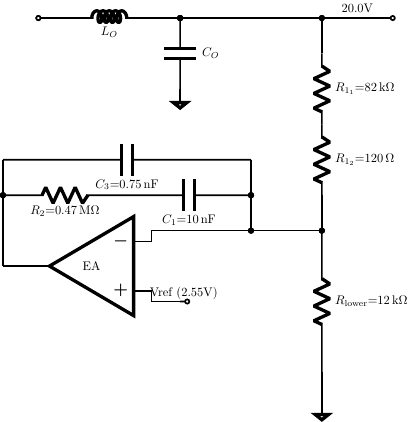

In [23]:
feedback = edcalc.smps.CurrentModeFeedback.buck(
    F_sw, 3 * R_I_sense, D_min, D_max, out[0].V, out[0].I, L_out[0], C_out[0], ESR_C_out[0], V_eap_ref, turns_ratios[0])
feedback.draw_circuit()